In [2]:
%matplotlib inline

In [1]:
from __future__ import division
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import sys
import numpy as np
import tensorflow as tf
from math import sqrt
import matplotlib.pyplot as plt
from scipy.misc import toimage

LEARNING_RATE = .001
BATCH_SIZE = 128

# color = true keeps color channels seperate
# with min_faces set to 14 - there will be 106 possible classifications
# image dimensions with param resize=0.5 will give 64x64 images
people = fetch_lfw_people(
    color=True,
    resize=0.5,
    slice_=(slice(61,189), slice(61,189)),
    min_faces_per_person=14
)
# import _pickle as pickle

# with open('people.pickle', 'rb') as f:
#     people = pickle.load(f, encoding='iso-8859-1')

X = people.images
y = np.asarray(people.target, dtype=np.int32)

labels = people.target_names

To visualize, here's the dataset we're playing with

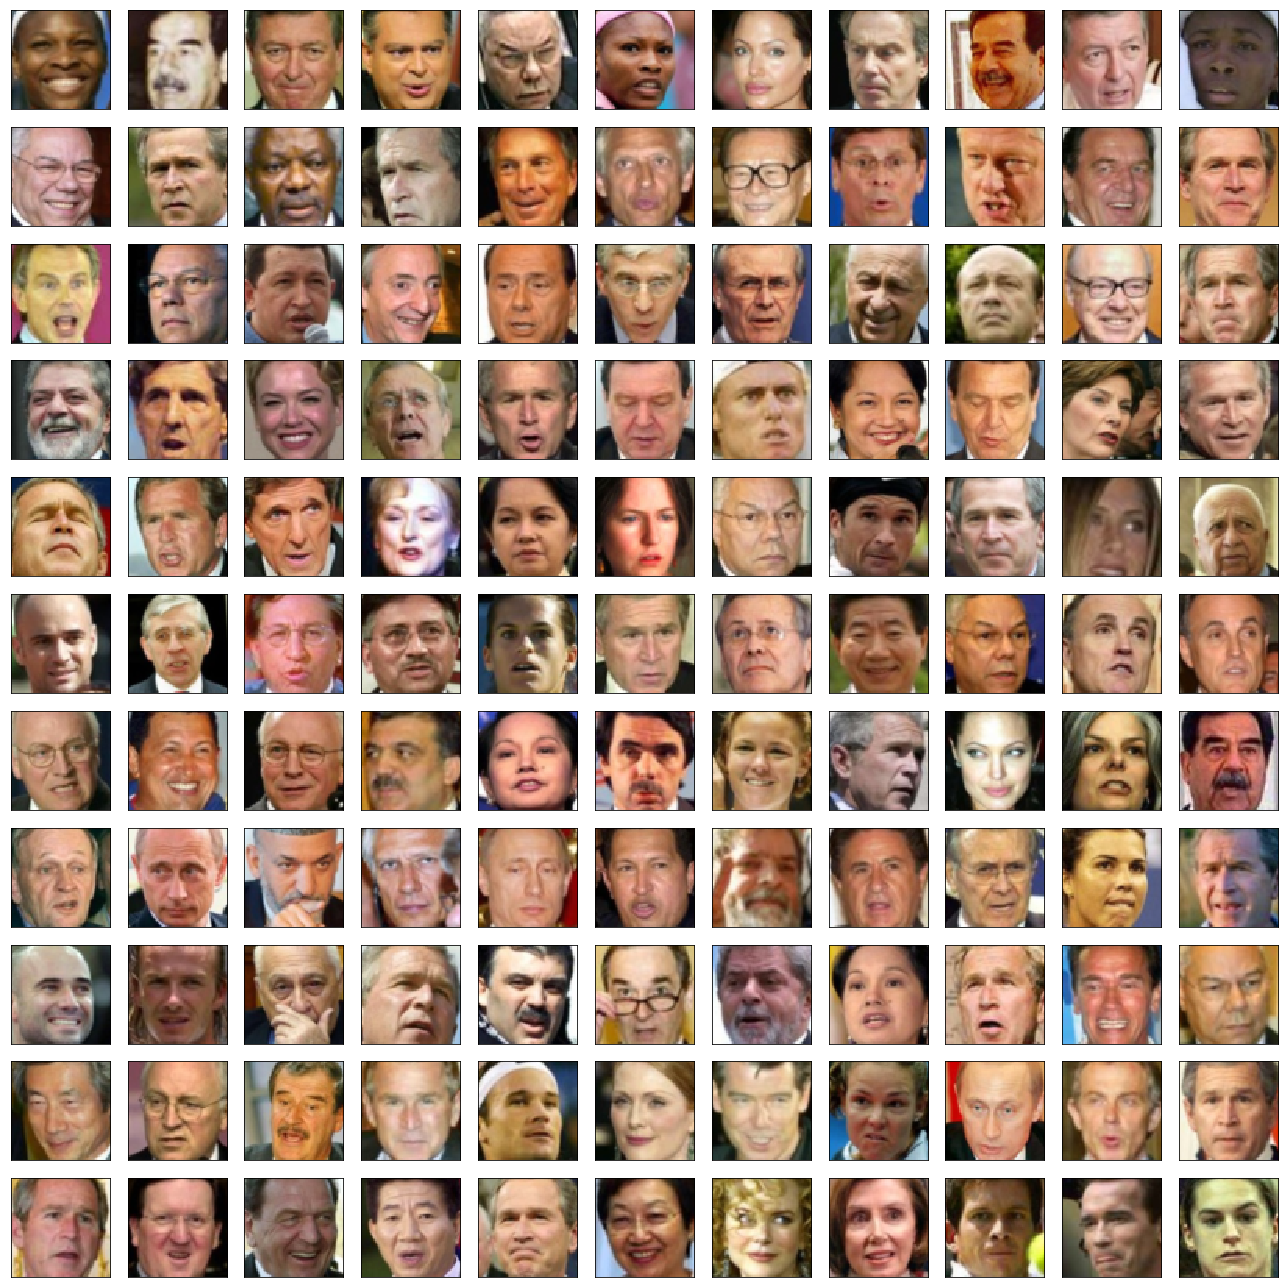

In [4]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning) 

plt.figure(figsize=(18, 18))

for i in range(0,121):
    d = plt.subplot(11, 11, i + 1)
    d.set_xticks([])
    d.set_yticks([])
    plt.imshow(toimage(X[i]))
    
plt.tight_layout()
plt.show()

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
def model(features, labels, mode):
    # il = tf.convert_to_tensor(features['x'])

    #input layer X
    # [64, 64, 3]
    c1 = tf.layers.conv2d(
        inputs=features['x'],
        filters=64,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu
    )
    print('c1', c1.get_shape())
    
    # this is pooling layer 1
    p1 = tf.layers.max_pooling2d(inputs=c1, pool_size=[2, 2], strides=2) # strides will reduce size by n / k
    # p1 Output Tensor Shape: [batch_size, 32, 32, 8]
    print('p1', p1.get_shape())

    c2 = tf.layers.conv2d(
        inputs=p1,
        filters=128,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu
    )
    print('c2', c2.get_shape())

    p2 = tf.layers.max_pooling2d(inputs=c2, pool_size=[2, 2], strides=2) # strides will reduce size by n / k
    print('p2', p2.get_shape())

    c3 = tf.layers.conv2d(
        inputs=c2,
        filters=256,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu
    )
    print('c3', c3.get_shape())

    p3 = tf.layers.max_pooling2d(inputs=c3, pool_size=[2, 2], strides=2) # strides will reduce size by n / k
    print('p3', p3.get_shape())
    p3_flat = tf.reshape(p3, [-1, 16 * 16 * 256])

    dense_layer = tf.layers.dense(
        inputs=p3_flat,
        units=1024,
        activation=tf.nn.relu
    )
    print('dense', dense_layer.get_shape())

    dropout_dense = tf.layers.dropout(inputs=dense_layer, rate=.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    print('dropout_dense', dropout_dense.get_shape())

    
    logits = tf.layers.dense(inputs=dropout_dense, units=106)
    print('logits', logits.get_shape())
    
    predictions = {
      "classes": tf.argmax(input=logits, axis=1),
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=106)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels,
        logits=logits
    )

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels,
          predictions=predictions["classes"]
      )
    }
    
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops
    )


We define the model as such 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

classifier_lfw = tf.estimator.Estimator(
    model_fn=model,
    model_dir="cnn-3conv-64-128-256-real-no-xavier-1024"
)

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': X_train},
    y=y_train,
    batch_size=BATCH_SIZE,
    num_epochs=None,
    shuffle=True
)
print('Starting training...')
classifier_lfw.train(
    input_fn=train_input_fn,
    steps=16000,
    hooks=[
        tf.train.LoggingTensorHook(
            tensors = {
                'probabilities': 'softmax_tensor'
            },
            every_n_iter=50
        )
    ]
)

In [4]:
pred_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': X_test},
    num_epochs=1,
    shuffle=False
)
predictions = classifier_lfw.predict(
    input_fn=pred_input_fn,
)

c = 0
l = 0
n = 0
to_render = []
for index, prediction in enumerate(predictions):
    c += int(y_test[index] == np.argmax(prediction['probabilities']))
    l += 1
    if not index % 10:
        to_render.append({
            'predicted': np.argmax(prediction['probabilities']),
            'actual': y_test[index]
        })

print ('Accuracy: %s' % float(c / l))

c1 (?, 64, 64, 64)
p1 (?, 32, 32, 64)
c2 (?, 32, 32, 128)
p2 (?, 16, 16, 128)
c3 (?, 32, 32, 256)
p3 (?, 16, 16, 256)
dense (?, 1024)
dropout_dense (?, 1024)
logits (?, 106)
INFO:tensorflow:Restoring parameters from cnn-3conv-64-128-256-real-no-xavier-1024\model.ckpt-20001
Accuracy: 0.8831400535236396


Predictions


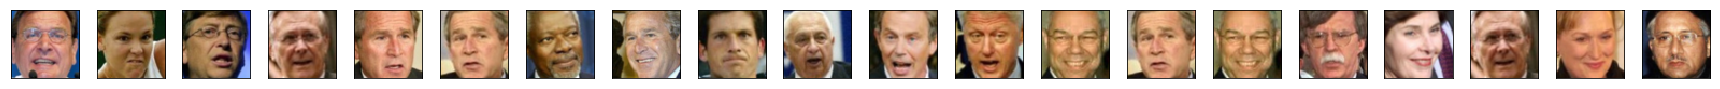

Actual


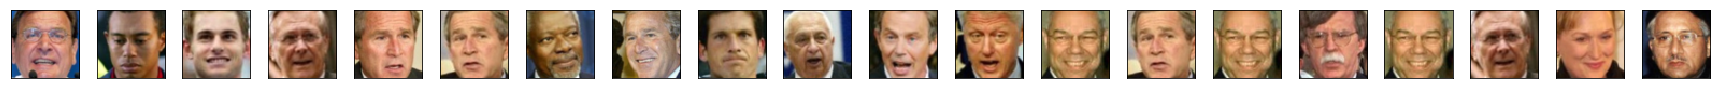

In [5]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning) 
    
plt.figure(figsize=(24, 24))
print('Predictions')
for index, item in enumerate(to_render[:20]):
    d = plt.subplot(1, 20, index + 1)
    d.set_xticks([])
    d.set_yticks([])
    plt.imshow(toimage(X_test[item['predicted']]))
    plt.tight_layout()
plt.show()

plt.figure(figsize=(24, 24))   
print("Actual")
for index, item in enumerate(to_render[:20]):
    d = plt.subplot(1, 20, index + 1)
    d.set_xticks([])
    d.set_yticks([])
    plt.imshow(toimage(X_test[item['actual']]))
    plt.tight_layout()
plt.show()